# 1. Import relevant libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from textblob import TextBlob, Word
import collections
import re
import string
import emoji
import time

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

import tensorflow as tf
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
# Please head to https://www.kaggle.com/c/nlp-getting-started/data
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# 2. Exploratory Data Analysis

In [4]:
train_df.shape

(7613, 5)

## 2.1 Class distribution

In [5]:
train_df["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [6]:
train_df["target"].value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

Text(0.5, 1.0, 'Real disaster tweets count')

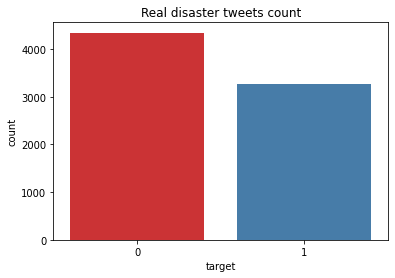

In [7]:
countplot = sns.countplot(x="target", data=train_df, palette="Set1")
countplot.set_title("Real disaster tweets count")

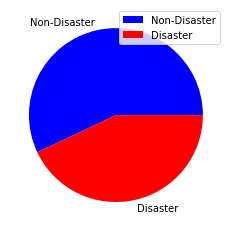

In [8]:
my_labels=["Non-Disaster", "Disaster"]
plt.pie(train_df['target'].value_counts(), labels=my_labels, colors = ["Blue","Red"])
plt.legend()
plt.show()

In [9]:
train_df.drop(columns=['id','keyword','location'], axis=1, inplace=True)
test_df.drop(columns=['keyword','location'], axis=1, inplace=True)

## 2.2 Wordclouds

### 2.2.1 Wordcloud for real disaster tweets

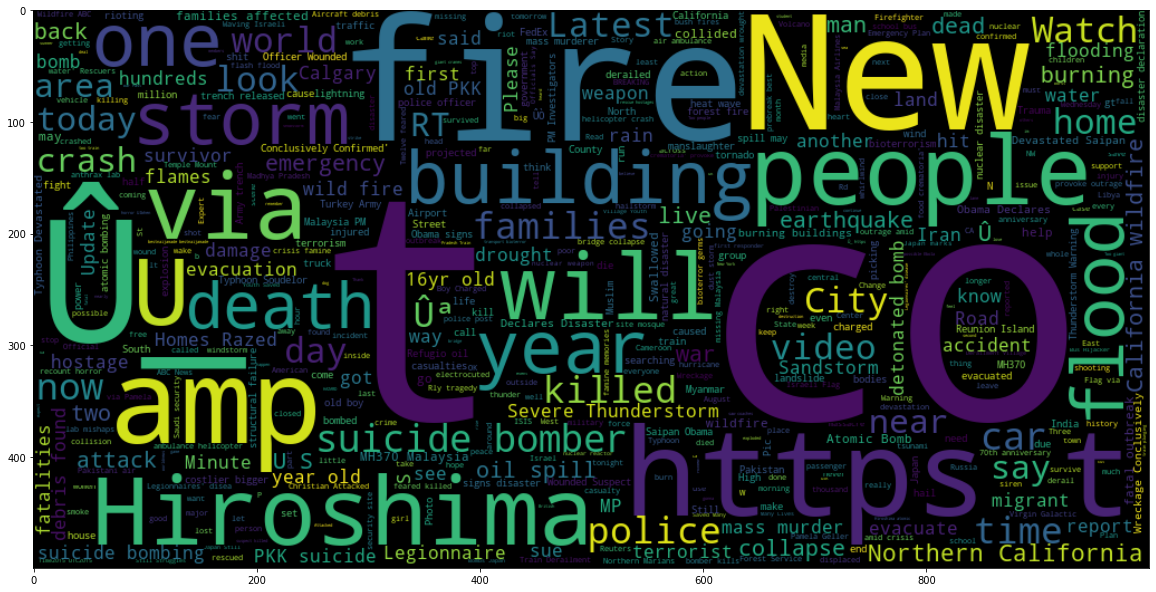

In [10]:
ax = plt.figure(figsize=(20,20))
wordcloud = WordCloud(max_words = 500 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(train_df[train_df.target == 1].text))
plt.imshow(wordcloud , interpolation = 'bilinear')

### 2.2.2 Wordcloud for non-disaster tweets

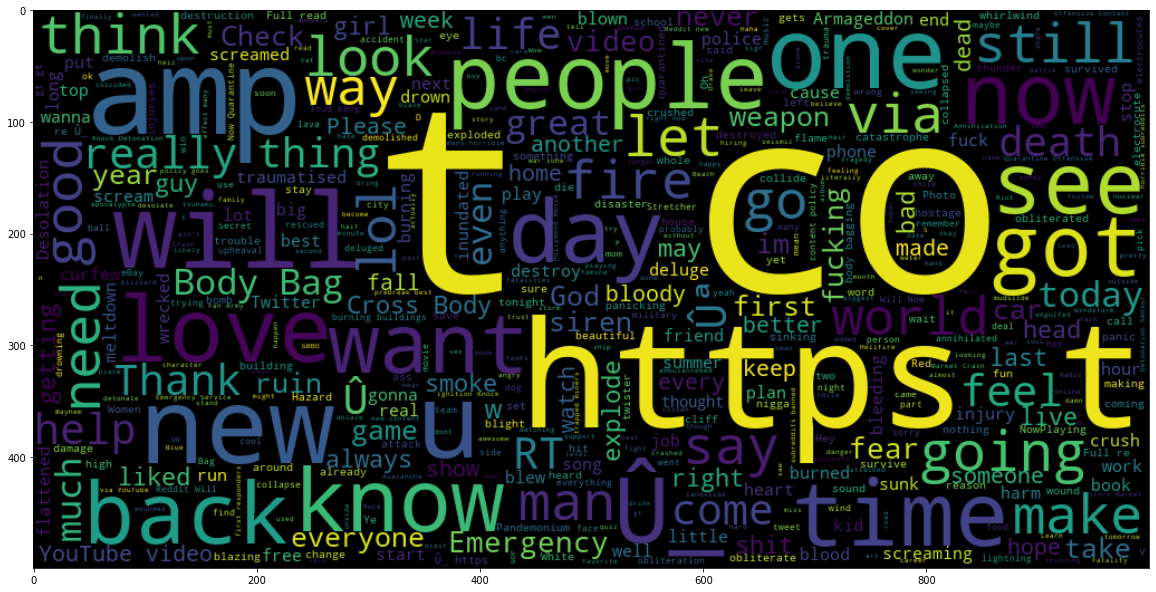

In [11]:
ax = plt.figure(figsize=(20,20))
wordcloud = WordCloud(max_words = 500 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(train_df[train_df.target == 0].text))
plt.imshow(wordcloud , interpolation = 'bilinear')

As we can see, there are many noisy words that should not be indicative of disaster. Let's clean this up

# 3. Preprocessing

## 3.1 Defining variables

In [12]:
stop_words = set(stopwords.words('english'))
contraction_map = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have",
}

all_punctuation = set(string.punctuation)
all_punctuation.add("...")
all_punctuation.add('’')
all_punctuation.add('-')
all_punctuation.add('“')
all_punctuation.add('[')
all_punctuation.add(']')
all_punctuation.add(' ')

Let's create some functions so it'll be easier to implement them down the line

## 3.2 Helper functions

### 3.2.1 Lower-casing text

In [13]:
def uncapitalize(text):
    return text.lower()

### 3.2.2 Remove emojis

In [14]:
def removeEmojis(text):
    allchars = [c for c in text]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI["en"]]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    return clean_text

### 3.2.3 Expand abbreviations

In [15]:
def expand_abbr(article):
    new_article = article
    for item in contraction_map:
        if item in article:
            new_article = article.replace(item,contraction_map[item])
    return new_article

### 3.2.4 Remove website urls

In [16]:
def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

### 3.2.5 Stripping all entities

In [17]:
def strip_all_entities(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

### 3.2.6 Lemmantization

In [18]:
def lemmatize_with_postag(text):
    sent = TextBlob(text)
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]    
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    return " ".join(lemmatized_list)

### 3.2.7 Remove stopwords

In [19]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    return filtered_sentence

### 3.2.8 Remove punctuations

In [20]:
def remove_punctuation(token_list):
    new_list = []
    for tok in token_list:
        if tok not in all_punctuation:
            new_list.append(tok)
    final_list = [x for x in new_list if not (x.isdigit() or x[0] == '-' and x[1:].isdigit())]
    final_sentence = " ".join(final_list)
    return final_sentence

## 3.3 Cleaning text

In [21]:
def clean_text(text):
    text = uncapitalize(text)
    text = removeEmojis(text)
    text = expand_abbr(text)
    text = strip_links(text)
    text = strip_all_entities(text)
    text = lemmatize_with_postag(text)
    cleaned_tokens = remove_stopwords(text)
    final_text = remove_punctuation(cleaned_tokens)
    return final_text
processed_train_df = train_df.copy(deep=True)
processed_train_df["text"] = processed_train_df.text.apply(clean_text)

In [22]:
processed_train_df.head()

,text,target
0,deed reason may allah forgive u,1
1,forest fire near la ronge sask canada,1
2,resident ask shelter place notify officer evac...,1
3,people receive evacuation order california,1
4,get send photo ruby smoke pours school,1


Looks good! Now let's take a look at more visualizations to easier understand our data

# 4. Further visualizations

## 4.1 Wordclouds 

### 4.1.1 Wordcloud for real disaster tweets

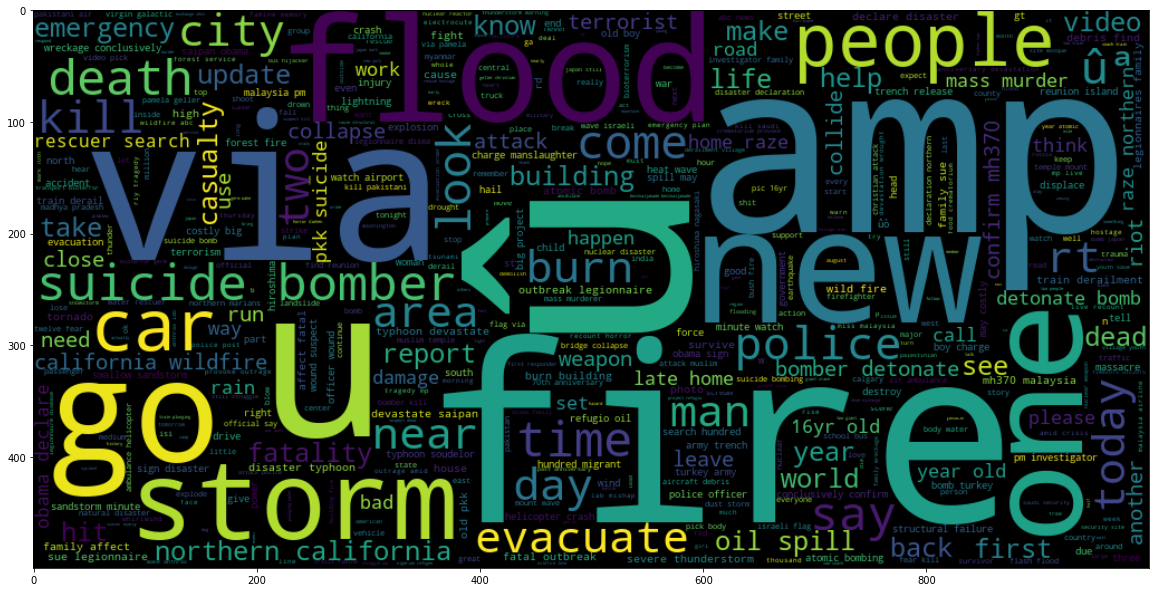

In [23]:
ax = plt.figure(figsize=(20,20))
wordcloud = WordCloud(max_words = 500, width = 1000, height = 500).generate(" ".join(processed_train_df[processed_train_df.target == 1].text))
plt.imshow(wordcloud , interpolation = 'bilinear')

### 4.1.2 Wordcloud for non-disaster tweets

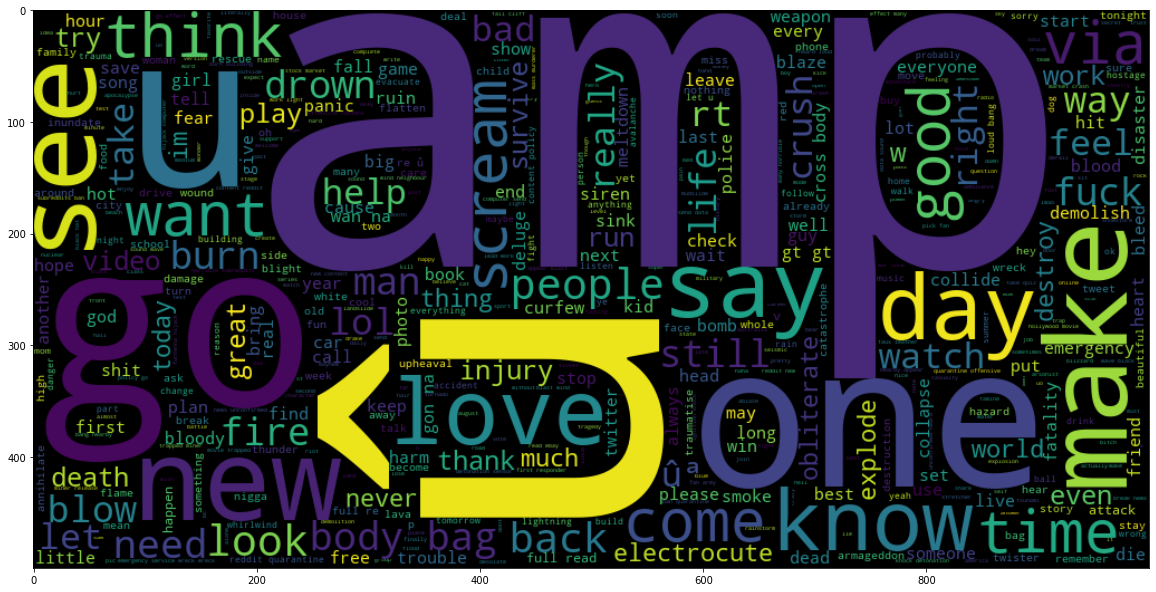

In [24]:
ax = plt.figure(figsize=(20,20))
wordcloud = WordCloud(max_words = 500, width = 1000, height = 500).generate(" ".join(processed_train_df[processed_train_df.target == 0].text))
plt.imshow(wordcloud , interpolation = 'bilinear')

## 4.2 n-grams of real disaster tweets

### 4.2.1 Preprocessing

In [25]:
def extract_ngrams(text, num):
    n_grams = ngrams(nltk.word_tokenize(text), num)
    return [' '.join(grams) for grams in n_grams]

In [26]:
disaster_text = " ".join(processed_train_df[processed_train_df.target == 1].text)

### 4.2.2 Uni-grams (most common words)

In [27]:
real_one_gram = extract_ngrams(disaster_text, 1)
real_one_gram_freq = collections.Counter(real_one_gram)
real_one_gram_freq.most_common(15)

[('fire', 269),
 ('kill', 157),
 ('amp', 135),
 ('bomb', 130),
 ('get', 121),
 ('via', 121),
 ('disaster', 113),
 ('suicide', 112),
 ('california', 111),
 ('crash', 111),
 ('year', 111),
 ('police', 108),
 ('u', 107),
 ('people', 105),
 ('home', 105)]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


Text(0.5, 1.0, 'unigram of real disaster tweets')

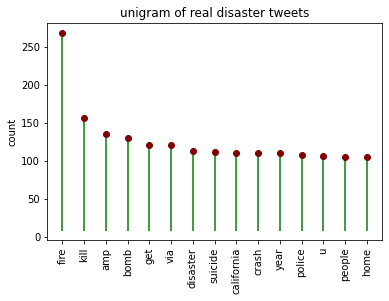

<Figure size 720x720 with 0 Axes>

In [28]:
freq_list = real_one_gram_freq.most_common(15)
fig,ax = plt.subplots()

fig = plt.figure(figsize=(10,10))
x = []
y = []
for item in freq_list:
    x.append(item[0])
    y.append(item[1])
    
ax.vlines(x,ymin=8, ymax=y, color="green")
ax.plot(x,y, "o", color="maroon")
ax.set_xticklabels(x, rotation=90)
ax.set_ylabel("count")
ax.set_title("unigram of real disaster tweets")

### 4.2.3 Bi-grams

In [29]:
real_bigram = extract_ngrams(disaster_text, 2)
real_bigram_freq = collections.Counter(real_bigram)
real_bigram_freq.most_common(15)

[('suicide bomber', 60),
 ('northern california', 41),
 ('oil spill', 38),
 ('california wildfire', 33),
 ('bomber detonate', 30),
 ('confirm mh370', 29),
 ('detonate bomb', 29),
 ('year old', 29),
 ('home raze', 29),
 ('mass murder', 28),
 ('late home', 28),
 ('raze northern', 28),
 ('16yr old', 28),
 ('pkk suicide', 28),
 ('rescuer search', 27)]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


Text(0.5, 1.0, 'bigram of real disaster tweets')

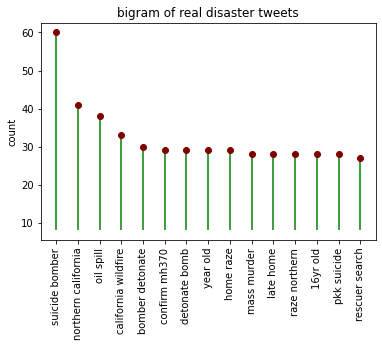

<Figure size 720x720 with 0 Axes>

In [30]:
freq_list = real_bigram_freq.most_common(15)
fig,ax = plt.subplots()

fig = plt.figure(figsize=(10,10))
x = []
y = []
for item in freq_list:
    x.append(item[0])
    y.append(item[1])
    
ax.vlines(x,ymin=8, ymax=y, color="green")
ax.plot(x,y, "o", color="maroon")
ax.set_xticklabels(x, rotation=90)
ax.set_ylabel("count")
ax.set_title("bigram of real disaster tweets")

### 4.2.4 Tri-grams

In [31]:
real_trigram = extract_ngrams(disaster_text, 3)
real_trigram_freq = collections.Counter(real_trigram)
real_trigram_freq.most_common(15)

[('suicide bomber detonate', 30),
 ('northern california wildfire', 29),
 ('late home raze', 28),
 ('home raze northern', 28),
 ('pkk suicide bomber', 28),
 ('bomber detonate bomb', 28),
 ('raze northern california', 27),
 ('16yr old pkk', 27),
 ('old pkk suicide', 27),
 ('family affect fatal', 26),
 ('affect fatal outbreak', 26),
 ('obama declare disaster', 25),
 ('declare disaster typhoon', 25),
 ('disaster typhoon devastate', 25),
 ('typhoon devastate saipan', 25)]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


Text(0.5, 1.0, 'trigram of real disaster tweets')

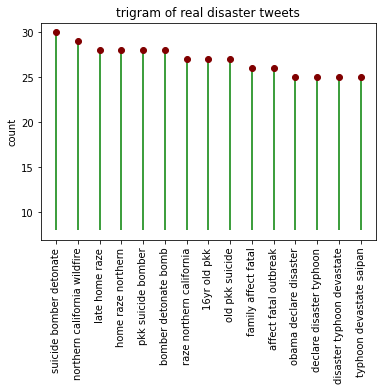

<Figure size 720x720 with 0 Axes>

In [32]:
freq_list = real_trigram_freq.most_common(15)
fig,ax = plt.subplots()

fig = plt.figure(figsize=(10,10))
x = []
y = []
for item in freq_list:
    x.append(item[0])
    y.append(item[1])
    
ax.vlines(x,ymin=8, ymax=y, color="green")
ax.plot(x,y, "o", color="maroon")
ax.set_xticklabels(x, rotation=90)
ax.set_ylabel("count")
ax.set_title("trigram of real disaster tweets")

## 4.3 n-grams of non-disaster tweets

### 4.3.1 Preprocessing

In [33]:
non_disaster_text = " ".join(processed_train_df[processed_train_df.target == 0].text)

### 4.3.2 Uni-grams (most common words)

In [34]:
non_disaster_one_gram = extract_ngrams(non_disaster_text, 1)
non_disaster_one_gram_freq = collections.Counter(non_disaster_one_gram)
non_disaster_one_gram_freq.most_common(15)

[('get', 317),
 ('like', 293),
 ('amp', 209),
 ('go', 197),
 ('new', 172),
 ('u', 165),
 ('one', 138),
 ('would', 134),
 ('make', 130),
 ('body', 117),
 ('see', 115),
 ('love', 113),
 ('bag', 108),
 ('come', 107),
 ('say', 106)]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


Text(0.5, 1.0, 'unigram of non-disaster tweets')

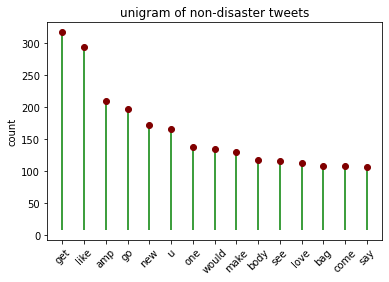

<Figure size 720x720 with 0 Axes>

In [35]:
freq_list = non_disaster_one_gram_freq.most_common(15)
fig,ax = plt.subplots()

fig = plt.figure(figsize=(10,10))
x = []
y = []
for item in freq_list:
    x.append(item[0])
    y.append(item[1])
    
ax.vlines(x,ymin=8, ymax=y, color="green")
ax.plot(x,y, "o", color="maroon")
ax.set_xticklabels(x, rotation=45)
ax.set_ylabel("count")
ax.set_title("unigram of non-disaster tweets")

### 4.3.3 Bi-grams

In [36]:
non_disaster_bigram = extract_ngrams(non_disaster_text, 2)
non_disaster_bigram_freq = collections.Counter(non_disaster_bigram)
non_disaster_bigram_freq.most_common(15)

[('body bag', 71),
 ('cross body', 39),
 ('look like', 36),
 ('like video', 34),
 ('gon na', 32),
 ('gt gt', 31),
 ('wan na', 30),
 ('feel like', 25),
 ('full re\x89û', 25),
 ('full read', 22),
 ('reddit quarantine', 21),
 ('content policy', 20),
 ('let u', 19),
 ('loud bang', 19),
 ('quarantine offensive', 18)]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


Text(0.5, 1.0, 'bigram of non-disaster tweets')

/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0, flags=flags)


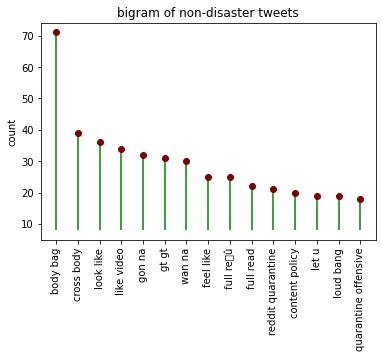

<Figure size 1296x72 with 0 Axes>

In [37]:
freq_list = non_disaster_bigram_freq.most_common(15)
fig,ax = plt.subplots()

fig = plt.figure(figsize=(18,1))
x = []
y = []
for item in freq_list:
    x.append(item[0])
    y.append(item[1])
    
ax.vlines(x,ymin=8, ymax=y, color="green")
ax.plot(x,y, "o", color="maroon")
ax.set_xticklabels(x, rotation=90)
ax.set_ylabel("count")
ax.set_title("bigram of non-disaster tweets")

### 4.3.4 Tri-grams

In [38]:
non_disaster_trigram = extract_ngrams(non_disaster_text, 3)
non_disaster_trigram_freq = collections.Counter(non_disaster_trigram)
non_disaster_trigram_freq.most_common(15)

[('cross body bag', 23),
 ('reddit quarantine offensive', 18),
 ('quarantine offensive content', 18),
 ('pick fan army', 17),
 ('gt gt gt', 16),
 ('reddit new content', 16),
 ('new content policy', 16),
 ('stock market crash', 16),
 ('full read ebay', 15),
 ('ignition knock detonation', 15),
 ('knock detonation sensor', 15),
 ('content policy go', 15),
 ('policy go effect', 15),
 ('go effect many', 15),
 ('effect many horrible', 15)]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


Text(0.5, 1.0, 'trigram of non-disaster tweets')

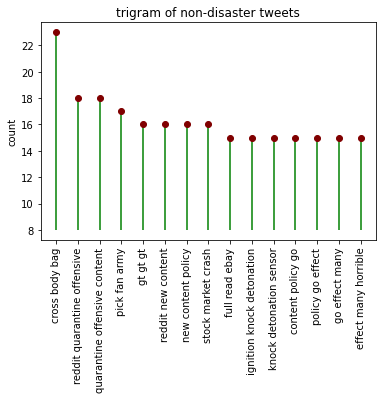

<Figure size 720x720 with 0 Axes>

In [39]:
freq_list = non_disaster_trigram_freq.most_common(15)
fig,ax = plt.subplots()

fig = plt.figure(figsize=(10,10))
x = []
y = []
for item in freq_list:
    x.append(item[0])
    y.append(item[1])
    
ax.vlines(x,ymin=8, ymax=y, color="green")
ax.plot(x,y, "o", color="maroon")
ax.set_xticklabels(x, rotation=90)
ax.set_ylabel("count")
ax.set_title("trigram of non-disaster tweets")

# 5. Importing word embeddings (GloVe)

In [40]:
embedding_df = processed_train_df.copy(deep=True)

In [41]:
word_embeddings = {}
f = open('/kaggle/input/glove6b/glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_embeddings[word] = coefs

# 6. Converting sentences into vectors

In [42]:
def get_sentence_vectors(text):
    sentence_vector = np.zeros((100,))
    if len(text) == 0:
        return sentence_vector
    else:
        tokens = text.split()
        for token in tokens:
            try:
                sentence_vector += word_embeddings[token]
            except:
                pass
        sentence_vector = sentence_vector/len(tokens)
        return sentence_vector

In [43]:
embedding_df["text"] = embedding_df.text.apply(get_sentence_vectors)

In [44]:
embedding_df.head()

,text,target
0,"[0.2608418346693118, 0.1459749974310398, 0.260...",1
1,"[-0.09041646452221487, -0.33786141872406006, 0...",1
2,"[0.025984912772070278, 0.02514095001176677, 0....",1
3,"[0.11781460493803024, 0.2293626017868519, 0.00...",1
4,"[0.0024518551571028574, 0.2925710466557315, 0....",1


# 7. Machine learning models

## 7.1 Train test split

In [45]:
x_train, x_test, y_train, y_test = train_test_split(embedding_df["text"],embedding_df["target"],test_size=0.2)

## 7.2 Naive Bayes

In [46]:
print(f"**********Naive Bayes**********")
model =  GaussianNB()
start = time.time()
model.fit(x_train.to_list(),y_train)
y_pred = model.predict(x_test.to_list())
f1score = f1_score(y_test,y_pred)
accuracyscore = accuracy_score(y_test,y_pred)
precisionscore = precision_score(y_test,y_pred)
recallscore = recall_score(y_test,y_pred)
print(f"f1_score: {f1score}")
print(f"Accuracy: {accuracyscore}")
print(f"Precision: {precisionscore}")
print(f"Recall: {recallscore}")
print('Time Taken :' + str(round(start - time.time(),2) * -1))
print("\n")

**********Naive Bayes**********
f1_score: 0.7198177676537586
Accuracy: 0.757715036112935
Precision: 0.7053571428571429
Recall: 0.7348837209302326
Time Taken :0.03




## 7.3 Logistic Regression

In [47]:
print(f"**********Logistic Regression**********")
model = LogisticRegression()
start = time.time()
model.fit(x_train.to_list(),y_train)
y_pred = model.predict(x_test.to_list())
f1score = f1_score(y_test,y_pred)
accuracyscore = accuracy_score(y_test,y_pred)
precisionscore = precision_score(y_test,y_pred)
recallscore = recall_score(y_test,y_pred)
print(f"f1_score: {f1score}")
print(f"Accuracy: {accuracyscore}")
print(f"Precision: {precisionscore}")
print(f"Recall: {recallscore}")
print('Time Taken :' + str(round(start - time.time(),2) * -1))
print("\n")

**********Logistic Regression**********
f1_score: 0.7100977198697068
Accuracy: 0.7662508207485227
Precision: 0.7478559176672385
Recall: 0.6759689922480621
Time Taken :0.17




## 7.4 Random Forest

In [48]:
print(f"**********Random Forest**********")
model = RandomForestClassifier()
start = time.time()
model.fit(x_train.to_list(),y_train)
y_pred = model.predict(x_test.to_list())
f1score = f1_score(y_test,y_pred)
accuracyscore = accuracy_score(y_test,y_pred)
precisionscore = precision_score(y_test,y_pred)
recallscore = recall_score(y_test,y_pred)
print(f"f1_score: {f1score}")
print(f"Accuracy: {accuracyscore}")
print(f"Precision: {precisionscore}")
print(f"Recall: {recallscore}")
print('Time Taken :' + str(round(start - time.time(),2) * -1))
print("\n")

**********Random Forest**********
f1_score: 0.7428087986463621
Accuracy: 0.8003939592908733
Precision: 0.8175046554934823
Recall: 0.6806201550387597
Time Taken :5.33




## 7.5 AdaBoost

In [49]:
print(f"**********AdaBoost**********")
model = AdaBoostClassifier()
start = time.time()
model.fit(x_train.to_list(),y_train)
y_pred = model.predict(x_test.to_list())
f1score = f1_score(y_test,y_pred)
accuracyscore = accuracy_score(y_test,y_pred)
precisionscore = precision_score(y_test,y_pred)
recallscore = recall_score(y_test,y_pred)
print(f"f1_score: {f1score}")
print(f"Accuracy: {accuracyscore}")
print(f"Precision: {precisionscore}")
print(f"Recall: {recallscore}")
print('Time Taken :' + str(round(start - time.time(),2) * -1))
print("\n")

**********AdaBoost**********
f1_score: 0.7109375
Accuracy: 0.7570584372948129
Precision: 0.7165354330708661
Recall: 0.7054263565891473
Time Taken :4.37




## 7.6 XGBoost

In [50]:
print(f"**********XGBoost**********")
model = XGBClassifier()
start = time.time()
model.fit(np.asarray(x_train.to_list()),y_train)
y_pred = model.predict(np.asarray(x_test.to_list()))
f1score = f1_score(y_test,y_pred)
accuracyscore = accuracy_score(y_test,y_pred)
precisionscore = precision_score(y_test,y_pred)
recallscore = recall_score(y_test,y_pred)
print(f"f1_score: {f1score}")
print(f"Accuracy: {accuracyscore}")
print(f"Precision: {precisionscore}")
print(f"Recall: {recallscore}")
print('Time Taken :' + str(round(start - time.time(),2) * -1))
print("\n")

**********XGBoost**********
[01:41:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


f1_score: 0.7407407407407408
Accuracy: 0.788575180564675
Precision: 0.7705192629815746
Recall: 0.7131782945736435
Time Taken :6.54




## 7.7 Support Vector Classifier

In [51]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
print(f"**********SVC**********")
model = SVC()
start = time.time()
model.fit(x_train.to_list(),y_train)
y_pred = model.predict(x_test.to_list())
f1score = f1_score(y_test,y_pred)
accuracyscore = accuracy_score(y_test,y_pred)
precisionscore = precision_score(y_test,y_pred)
recallscore = recall_score(y_test,y_pred)
print(f"f1_score: {f1score}")
print(f"Accuracy: {accuracyscore}")
print(f"Precision: {precisionscore}")
print(f"Recall: {recallscore}")
print('Time Taken :' + str(round(start - time.time(),2) * -1))
print("\n")

**********SVC**********
f1_score: 0.7460184409052808
Accuracy: 0.8010505581089954
Precision: 0.8120437956204379
Recall: 0.689922480620155
Time Taken :2.94




## 7.8 Stacking

In [52]:
print("**********Stacking**********")
start = time.time()
estimators = [("xgb", XGBClassifier()), ("SVC",SVC()), ("rfe",RandomForestClassifier())]
final_estimator = LinearSVC()
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)
stacking_clf.fit(np.asarray(x_train.to_list()),y_train)
y_pred = stacking_clf.predict(np.asarray(x_test.to_list()))
f1score = f1_score(y_test,y_pred)
accuracyscore = accuracy_score(y_test,y_pred)
precisionscore = precision_score(y_test,y_pred)
recallscore = recall_score(y_test,y_pred)
print(f"f1_score: {f1score}")
print(f"Accuracy: {accuracyscore}")
print(f"Precision: {precisionscore}")
print(f"Recall: {recallscore}")
print('Time Taken :' + str(round(start - time.time(),2) * -1))
print("\n")

**********Stacking**********
[01:42:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:42:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:42:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:42:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:42:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:42:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
f1_score: 0.7491749174917491
Accuracy: 0.8003939592908733
Precision: 0.800705467372134
Recall: 0.703875968992248
Time Taken :71.15




# 8. Artificial Neural Networks (ANNs)

## 8.1 Stop function

In [53]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch,logs={}):
    if(logs.get('accuracy')>0.90):
      print("\nReached 90% accuracy so cancelling training")
      self.model.stop_training=True

## 8.2 Creating model

In [54]:
callbacks = myCallback()
ann_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])
ann_model.fit(np.asarray(x_train.to_list()), y_train, epochs=1000, validation_data=(np.asarray(x_test.to_list()), y_test), callbacks=[callbacks])


Epoch 1/1000
191/191 [==============================] - 2s 7ms/step - loss: 0.5670 - accuracy: 0.7134 - val_loss: 0.4738 - val_accuracy: 0.7846
Epoch 2/1000
191/191 [==============================] - 1s 4ms/step - loss: 0.4713 - accuracy: 0.7870 - val_loss: 0.4576 - val_accuracy: 0.7866
Epoch 3/1000
191/191 [==============================] - 1s 4ms/step - loss: 0.4353 - accuracy: 0.8104 - val_loss: 0.4573 - val_accuracy: 0.7827
Epoch 4/1000
191/191 [==============================] - 1s 3ms/step - loss: 0.4168 - accuracy: 0.8080 - val_loss: 0.4650 - val_accuracy: 0.7873
Epoch 5/1000
191/191 [==============================] - 1s 4ms/step - loss: 0.4097 - accuracy: 0.8206 - val_loss: 0.4386 - val_accuracy: 0.8017
Epoch 6/1000
191/191 [==============================] - 1s 4ms/step - loss: 0.3780 - accuracy: 0.8424 - val_loss: 0.4464 - val_accuracy: 0.8004
Epoch 7/1000
191/191 [==============================] - 1s 3ms/step - loss: 0.3752 - accuracy: 0.8355 - val_loss: 0.4592 - val_accuracy:

## 8.3 Evaluate ANN

In [55]:
ann_model.evaluate(np.asarray(x_test.to_list()),y_test)

48/48 [==============================] - 0s 1ms/step - loss: 0.5837 - accuracy: 0.7984


[0.5836949348449707, 0.7984241843223572]

# 9. Preperation for LSTM

## 9.1 Create word frequency

In [56]:
processed_train_df.head(10)

,text,target
0,deed reason may allah forgive u,1
1,forest fire near la ronge sask canada,1
2,resident ask shelter place notify officer evac...,1
3,people receive evacuation order california,1
4,get send photo ruby smoke pours school,1
5,update california hwy close direction due lake...,1
6,heavy rain cause flash flooding street manitou...,1
7,top hill see fire wood,1
8,emergency evacuation happen building across st...,1
9,afraid tornado come area,1


In [57]:
def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

In [58]:
counter = counter_word(processed_train_df.text)

In [59]:
num_words = len(counter)
#Max number of words in a sequence
max_length = 30

## 9.2 Create train test split

In [60]:
x_train, x_test, y_train, y_test = train_test_split(processed_train_df["text"],processed_train_df["target"],test_size=0.3)

## 9.3 Word index

In [61]:
tokenizer = Tokenizer(num_words = num_words)
tokenizer.fit_on_texts(x_train)

In [62]:
word_index = tokenizer.word_index

## 9.4 Create word sequence

In [63]:
train_sequences = tokenizer.texts_to_sequences(x_train)
train_sequences[:5]

[[2174, 255, 109, 12, 138, 2, 351],
 [4031, 139, 55],
 [630, 1516],
 [93, 185, 4032, 1016, 4033, 565, 68, 6, 103, 1771, 2788],
 [599, 4034]]

## 9.5 Text padding

In [64]:
train_padded = pad_sequences(
    train_sequences, maxlen= max_length, padding='post', truncating = 'post'
)

In [65]:
test_sequences = tokenizer.texts_to_sequences(x_test)
test_sequences[:5]

[[8, 440, 383, 1183, 837, 1470, 724, 1435, 1471, 165, 32, 62, 5959, 75, 2602],
 [2, 18, 167, 1550, 6600, 2369, 372, 2753, 105],
 [6271, 3591, 2432, 1449, 77, 2119, 6272, 1394, 592, 6273, 3, 780],
 [423, 3164, 1247, 1824, 2940, 979, 577],
 [354, 834, 194, 1255, 1110, 313, 795, 85]]

In [66]:
test_padded = pad_sequences(
    test_sequences, maxlen= max_length, padding='post', truncating = 'post'
)

In [67]:
print(x_train.head(1))
print(train_sequences[0])

835    draco also please would much like link
Name: text, dtype: object
[2174, 255, 109, 12, 138, 2, 351]


# 10. Building LSTM model

## 10.1 Stop function

In [68]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch,logs={}):
    if(logs.get('accuracy')>=0.85):
      print("\nReached 85% accuracy so cancelling training")
      self.model.stop_training=True
callbacks = myCallback()

## 10.2 Creating model

In [69]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(num_words, 32, input_length=max_length),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(200),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

In [70]:
history = lstm_model.fit(
    train_padded,
    y_train,
    epochs=30,
    verbose=1,
    validation_data=(test_padded, y_test),
    callbacks=[callbacks]
)

Epoch 1/30
167/167 [==============================] - 16s 81ms/step - loss: 0.6734 - accuracy: 0.5827 - val_loss: 0.4740 - val_accuracy: 0.7885
Epoch 2/30
167/167 [==============================] - 13s 77ms/step - loss: 0.3927 - accuracy: 0.8416 - val_loss: 0.5140 - val_accuracy: 0.7806
Epoch 3/30
167/167 [==============================] - 13s 75ms/step - loss: 0.2583 - accuracy: 0.9076 - val_loss: 0.5060 - val_accuracy: 0.7706

Reached 85% accuracy so cancelling training


## 10.3 Evaluate LSTM

In [71]:
lstm_model.evaluate(test_padded,y_test)

72/72 [==============================] - 2s 22ms/step - loss: 0.5060 - accuracy: 0.7706


[0.5059581995010376, 0.7705779075622559]

# 11. Output

## 11.1 Preprocess test dataset

In [72]:
def clean_text(text):
    text = uncapitalize(text)
    text = removeEmojis(text)
    text = expand_abbr(text)
    text = strip_links(text)
    text = strip_all_entities(text)
    text = lemmatize_with_postag(text)
    cleaned_tokens = remove_stopwords(text)
    final_text = remove_punctuation(cleaned_tokens)
    return final_text

processed_test_df = test_df.copy(deep=True)
processed_test_df["text"] = processed_test_df.text.apply(clean_text)

final_train_df = train_df.copy(deep=True)
final_train_df["text"] = final_train_df.text.apply(clean_text)

## 11.2 Convert text to vectors

In [73]:
test_embedding_df = processed_test_df.copy(deep=True)
test_embedding_df["text"] = test_embedding_df.text.apply(get_sentence_vectors)

final_train_embedding = final_train_df.copy(deep=True)
final_train_embedding["text"] = final_train_embedding.text.apply(get_sentence_vectors)

In [74]:
final_train_embedding.head()

,text,target
0,"[0.2608418346693118, 0.1459749974310398, 0.260...",1
1,"[-0.09041646452221487, -0.33786141872406006, 0...",1
2,"[0.025984912772070278, 0.02514095001176677, 0....",1
3,"[0.11781460493803024, 0.2293626017868519, 0.00...",1
4,"[0.0024518551571028574, 0.2925710466557315, 0....",1


## 11.3 Output predictions

In [75]:
estimators = [("xgb", XGBClassifier()), ("SVC",SVC()), ("rfe",RandomForestClassifier())]
final_estimator = LinearSVC()
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)
stacking_clf.fit(np.asarray(final_train_embedding["text"].to_list()),final_train_embedding["target"])
predictions = stacking_clf.predict(np.asarray(test_embedding_df["text"].to_list()))

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:44:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:45:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:45:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:45:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:45:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:45:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [76]:
predictions_df = pd.Series(np.array(predictions).flatten()).to_frame()
result_df = pd.concat([test_df,predictions_df], axis = 1)
result_df.drop(columns=['text'], axis=1, inplace=True)
result_df = result_df.rename(columns={0: "target"})
result_df['target'] = result_df['target'].map(lambda a: int(a))

In [77]:
result_df.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1


In [78]:
result_df.to_csv('result.csv',index=False)